In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import tensorflow as tf
import tensorflow.keras as keras
from keras import backend as K
import tensorflow.keras as tfk

from sklearn.preprocessing import StandardScaler
from keras.callbacks import Callback

from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, LayerNormalization

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
plt.style.use('seaborn')

from tensorflow.keras.preprocessing import timeseries_dataset_from_array

Using TensorFlow backend.


In [2]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    x = tf.math.reduce_mean(x[:,:,:], axis=-1) # Convert (batch, seq_len, n_attributes) to (batch, seq_len)
    time_linear = self.weights_linear * x + self.bias_linear
    time_linear = tf.expand_dims(time_linear, axis=-1) # (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # (batch, seq_len, 2)
  def get_config(self):
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

In [3]:
class SingleAttention(Layer):
    def __init__(self, d_k, d_v):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

    def build(self, input_shape):
        self.query = Dense(self.d_k, input_shape=input_shape,                                                       kernel_initializer='glorot_uniform',                                                        bias_initializer='glorot_uniform')
        self.key = Dense(self.d_k, input_shape=input_shape,                                                         kernel_initializer='glorot_uniform',                                                        bias_initializer='glorot_uniform')
        self.value = Dense(self.d_v, input_shape=input_shape,                                                       kernel_initializer='glorot_uniform',                                                        bias_initializer='glorot_uniform')

    def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
        q = self.query(inputs[0])
        k = self.key(inputs[1])

        attn_weights = tf.matmul(q, k, transpose_b=True)
        attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
        attn_weights = tf.nn.softmax(attn_weights, axis=-1)

        v = self.value(inputs[2])
        attn_out = tf.matmul(attn_weights, v)
        return attn_out  


In [4]:
class MultiAttention(Layer):
    def __init__(self, d_k, d_v, n_heads):
        super(MultiAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.attn_heads = list()

    def build(self, input_shape):
        for n in range(self.n_heads):
            self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
        self.linear = Dense(3, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')

    def call(self, inputs):
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
        concat_attn = tf.concat(attn, axis=-1)
        multi_linear = self.linear(concat_attn)
        return multi_linear 

In [5]:
class TransformerEncoder(Layer):
    def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.attn_heads = list()
        self.dropout_rate = dropout

    def build(self, input_shape):
        self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
        self.attn_dropout = Dropout(self.dropout_rate)
        self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

        self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
        self.ff_conv1D_2 = Conv1D(filters=3, kernel_size=1) # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
        self.ff_dropout = Dropout(self.dropout_rate)
        self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
    
    def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
        attn_layer = self.attn_multi(inputs)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)

        ff_layer = self.ff_conv1D_1(attn_layer)
        ff_layer = self.ff_conv1D_2(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(inputs[0] + ff_layer)
        return ff_layer 


    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'d_k': self.d_k,
                    'd_v': self.d_v,
                    'n_heads': self.n_heads,
                    'ff_dim': self.ff_dim,
                    'attn_heads': self.attn_heads,
                    'dropout_rate': self.dropout_rate})
        return config

In [6]:
#class ModelTransformers(keras.Model):
def create_model(input_shape, output_len, d_k=256, d_v=256, n_heads=12, ff_dim=256, n_transfomerencoder=3, n_dense_layers=1, n_neurons_dense_layer=64, dropout_rate=0.1):
    '''Initialize time and transformer layers'''

    time_embedding = Time2Vector(input_shape[0])
    """transfomers_encoders = [TransformerEncoder(d_k, d_v, n_heads, ff_dim) for n_encoder in range(n_transfomerencoder)]"""
    """attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)"""
    """attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)"""
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

    '''Construct model'''
    in_seq = Input(shape=input_shape)
    print(in_seq)
    x = time_embedding(in_seq)
    print(x)
    x = Concatenate(axis=-1)([in_seq, x])
    print(x)

    """for t_encoder_layer in transfomers_encoders:
        x = t_encoder_layer((x, x, x))"""

    #x = attn_layer1((x, x, x))
    #x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))

    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(n_neurons_dense_layer, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    #regression
    out = Dense(output_len, activation='linear')(x)

    model = Model(inputs=in_seq, outputs=out)
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
    return model

In [25]:
X_train, y_train, X_val, y_val = preprocess_time_series_v1(df, split_fraction=0.7, 
                            past_timestamps=96, forecasting_horizon=6, 
                            standarize=True, metafeatures=False, tendency=False)

                      Date  value
0      2016-01-02 23:00:00  24151
1      2016-01-03 00:00:00  22170
2      2016-01-03 01:00:00  20691
3      2016-01-03 02:00:00  19737
4      2016-01-03 03:00:00  19437
...                    ...    ...
34940  2019-12-28 19:00:00  29282
34941  2019-12-28 20:00:00  29266
34942  2019-12-28 21:00:00  28022
34943  2019-12-28 22:00:00  25964
34944  2019-12-28 23:00:00  24680

[34945 rows x 2 columns]
(24460,)
(10484,)
[[-1.0298226 ]
 [-1.46644403]
 [-1.79242237]
 ...
 [-1.2762349 ]
 [-1.32274026]
 [-1.35117245]] (24460, 1)
Tamano de la serie temporal 2
Tamano de la serie temporal 2
(24359, 96, 1, 1)


Epoch 1/10
96/96 [==============================] - 14s 124ms/step - loss: 0.8402 - mean_absolute_error: 0.7737 - val_loss: 0.2439 - val_mean_absolute_error: 0.3957
Epoch 2/10
96/96 [==============================] - 11s 110ms/step - loss: 0.2000 - mean_absolute_error: 0.3478 - val_loss: 0.1299 - val_mean_absolute_error: 0.2752
Epoch 3/10
96/96 [==============================] - 11s 114ms/step - loss: 0.1176 - mean_absolute_error: 0.2597 - val_loss: 0.1137 - val_mean_absolute_error: 0.2510
Epoch 4/10
96/96 [==============================] - 11s 116ms/step - loss: 0.0908 - mean_absolute_error: 0.2284 - val_loss: 0.0846 - val_mean_absolute_error: 0.2179
Epoch 5/10
96/96 [==============================] - 11s 110ms/step - loss: 0.0775 - mean_absolute_error: 0.2097 - val_loss: 0.0736 - val_mean_absolute_error: 0.2041
Epoch 6/10
96/96 [==============================] - 11s 110ms/step - loss: 0.0712 - mean_absolute_error: 0.2005 - val_loss: 0.0687 - val_mean_absolute_error: 0.2009
Epoch 7/10

KeyError: 'val_mse'

In [ ]:
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)


In [34]:
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model.predict(X_val)]
y = [y[0] for y in y_val]
# Creating the frame to store both predictions
days = d['dt'].values[-len(y):]
frame = pd.concat([
 pd.DataFrame({'day': days, 'temp': y, 'type': 'original'}),
 pd.DataFrame({'day': days, 'temp': yhat, 'type': 'forecast'})
])
"""# Creating the unscaled values column
frame['temp_absolute'] = [(x * train_std['temp']) + train_mean['temp'] for x in frame['temp']]
# Pivoting
pivoted = frame.pivot_table(index='day', columns='type')
pivoted.columns = ["_".join(x).strip() for x in pivoted.columns.values]
pivoted['res'] = pivoted['temp_absolute_original'] - pivoted['temp_absolute_forecast']
pivoted["res_abs"] = [abs(x) for x in pivoted['res']]"""

NameError: name 'd' is not defined

In [31]:
sns.lineplot(
    data=np.array(y_val),style="event",
    markers=True, marker='o'
)

"""out = 6
init = 0
for y_predict_horizon in yhat:
    plt.plot(np.arange(init, out), np.array(y_predict_horizon), 'ro',
                 label='Predicted Future')
    print(y_predict_horizon)
    init += 1
    out += 1
plt.show()

print("MAE:", mae)"""

ValueError: Must pass 2-d input. shape=(10383, 6, 1)

In [9]:
print(X_train.shape[2])
print(y_train.shape)

1
(35889, 1, 1)


In [13]:
from tensorflow.keras.utils import plot_model

model = create_model(input_shape=(X_train.shape[1],1))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

KerasTensor(type_spec=TensorSpec(shape=(None, 96, 1), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 96, 2), dtype=tf.float32, name=None), name='time2_vector_3/concat:0', description="created by layer 'time2_vector_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 96, 3), dtype=tf.float32, name=None), name='concatenate_3/concat:0', description="created by layer 'concatenate_3'")
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [10]:
model = create_model(input_shape=(X_train.shape[1],1))
print(model.summary())

batch_size = 128
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=35, 
                    validation_data=(X_val, y_val))  




###############################################################################
'''Calculate predictions and metrics'''





KerasTensor(type_spec=TensorSpec(shape=(None, 96, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 96, 2), dtype=tf.float32, name=None), name='time2_vector/concat:0', description="created by layer 'time2_vector'")
KerasTensor(type_spec=TensorSpec(shape=(None, 96, 3), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 1)]      0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 96, 2)        384         input_1[0][0]                    
_______________________

NameError: name 'X_test' is not defined

In [11]:
#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))


 
Evaluation metrics
Training Data - Loss: 0.0035, MAE: 0.0457, MAPE: 40.2114
Validation Data - Loss: 0.0031, MAE: 0.0426, MAPE: 40.7002


In [18]:
model.save("transformer_1decoder.h5")

NotImplementedError: Layer Time2Vector has arguments in `__init__` and therefore must override `get_config`.

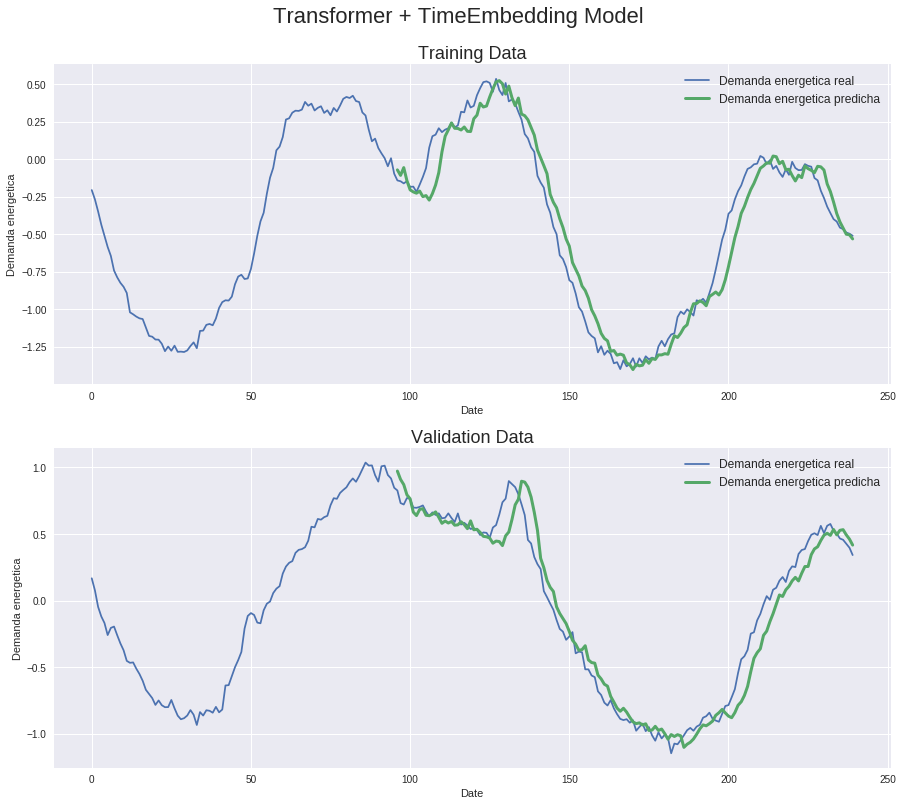

In [44]:
seq_len = 96
fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(X_train[:144+seq_len, 3], label='Demanda energetica real')
ax11.plot(np.arange(seq_len, 144+seq_len), train_pred[:144], linewidth=3, label='Demanda energetica predicha')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('Demanda energetica')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(X_val[:144+seq_len, 3], label='Demanda energetica real')
ax21.plot(np.arange(seq_len, 144+seq_len), val_pred[:144], linewidth=3, label='Demanda energetica predicha')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Demanda energetica')
ax21.legend(loc="best", fontsize=12)

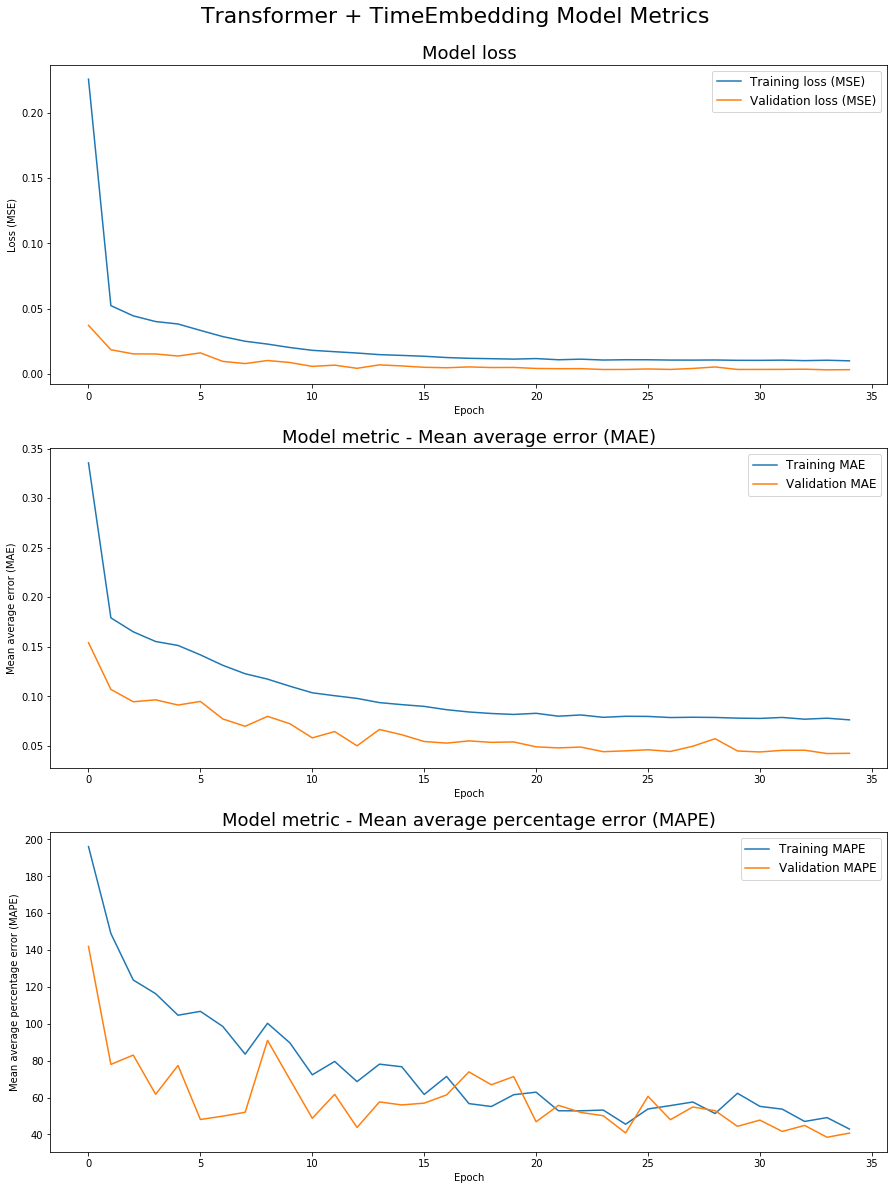

In [19]:
fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)